In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

In [39]:
# Check if CUDA is available
device = torch.device('cpu')
# if torch.cuda.is_available():
#    device = torch.device('cuda:0')

torch.set_default_device(device)
print(f"Using device = {torch.get_default_device()}")

Using device = cpu


In [ ]:
import json

def nps_seq_to_tensor(seq):
    return torch.tensor(seq, dtype=torch.float32)#.reshape((-1, 1, 1))

class ChartDataset(Dataset):

    def __init__(self, df, convert_to_tensor=False):

        if convert_to_tensor:
            self.data = list(map(
                lambda seq: nps_seq_to_tensor(json.loads(seq)),
                df['Seq']
            ))
            self.meters = list(map(
                lambda m: torch.tensor([[float(m)]], dtype=torch.float32),
                df['Meter']
            ))
        else:
            self.data = list(map(
                # lambda seq: nps_seq_to_tensor(json.loads(seq)),
                lambda seq: np.array(json.loads(seq)),
                df['Seq']
            ))
            self.meters = df['Meter'].to_list()
        
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, i):
        return self.meters[i], self.data[i]

In [4]:
df = pd.read_csv('seq_dataset.csv')
print(f'loaded {len(df)} items')

loaded 3137 items


In [28]:
df[df['Meter'] == 43]

,Name,Hash,Meter,Seq
1676,ECS13 - Speed/[43] [450] Another Lovely Beyond,85a6c1f24afbfb9deb780121c0354c1dae6fa608,43,"[0.15890322222222222, 2.274088888888889, 3.725..."
1677,ECS13 - Speed/[43] [440] Jehovah's YaHVeH,7f741aab0c49424a0b6d3d825de0c41bcf62d014,43,"[0.46300166528925707, 2.9017867685950414, 3.66..."
1678,ECS13 - Speed/[43] [464] Never Die,2732e936cff5038a7cbfa68431fe55df9c73e57d,43,"[0.6929048889714626, 1.8785980836801424, 1.944..."


In [84]:
all_data = ChartDataset(df)

In [85]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, LinearColorMapper
from bokeh import palettes

output_notebook()

Loading BokehJS ...

In [15]:
def ewma_vectorized(data, alpha, offset=None, dtype=None, order='C', out=None):
    """
    Calculates the exponential moving average over a vector.
    Will fail for large inputs.
    :param data: Input data
    :param alpha: scalar float in range (0,1)
        The alpha parameter for the moving average.
    :param offset: optional
        The offset for the moving average, scalar. Defaults to data[0].
    :param dtype: optional
        Data type used for calculations. Defaults to float64 unless
        data.dtype is float32, then it will use float32.
    :param order: {'C', 'F', 'A'}, optional
        Order to use when flattening the data. Defaults to 'C'.
    :param out: ndarray, or None, optional
        A location into which the result is stored. If provided, it must have
        the same shape as the input. If not provided or `None`,
        a freshly-allocated array is returned.
    """
    data = np.array(data, copy=False)

    if dtype is None:
        if data.dtype == np.float32:
            dtype = np.float32
        else:
            dtype = np.float64
    else:
        dtype = np.dtype(dtype)

    if data.ndim > 1:
        # flatten input
        data = data.reshape(-1, order)

    if out is None:
        out = np.empty_like(data, dtype=dtype)
    else:
        assert out.shape == data.shape
        assert out.dtype == dtype

    if data.size < 1:
        # empty input, return empty array
        return out

    if offset is None:
        offset = data[0]

    alpha = np.array(alpha, copy=False).astype(dtype, copy=False)

    # scaling_factors -> 0 as len(data) gets large
    # this leads to divide-by-zeros below
    scaling_factors = np.power(1. - alpha, np.arange(data.size + 1, dtype=dtype),
                               dtype=dtype)
    # create cumulative sum array
    np.multiply(data, (alpha * scaling_factors[-2]) / scaling_factors[:-1],
                dtype=dtype, out=out)
    np.cumsum(out, dtype=dtype, out=out)

    # cumsums / scaling
    out /= scaling_factors[-2::-1]

    if offset != 0:
        offset = np.array(offset, copy=False).astype(dtype, copy=False)
        # add offsets
        out += offset * scaling_factors[1:]

    return out

def ewma_vectorized_2d(data, alpha, axis=None, offset=None, dtype=None, order='C', out=None):
    """
    Calculates the exponential moving average over a given axis.
    :param data: Input data, must be 1D or 2D array.
    :param alpha: scalar float in range (0,1)
        The alpha parameter for the moving average.
    :param axis: The axis to apply the moving average on.
        If axis==None, the data is flattened.
    :param offset: optional
        The offset for the moving average. Must be scalar or a
        vector with one element for each row of data. If set to None,
        defaults to the first value of each row.
    :param dtype: optional
        Data type used for calculations. Defaults to float64 unless
        data.dtype is float32, then it will use float32.
    :param order: {'C', 'F', 'A'}, optional
        Order to use when flattening the data. Ignored if axis is not None.
    :param out: ndarray, or None, optional
        A location into which the result is stored. If provided, it must have
        the same shape as the desired output. If not provided or `None`,
        a freshly-allocated array is returned.
    """
    data = np.array(data, copy=False)

    assert data.ndim <= 2

    if dtype is None:
        if data.dtype == np.float32:
            dtype = np.float32
        else:
            dtype = np.float64
    else:
        dtype = np.dtype(dtype)

    if out is None:
        out = np.empty_like(data, dtype=dtype)
    else:
        assert out.shape == data.shape
        assert out.dtype == dtype

    if data.size < 1:
        # empty input, return empty array
        return out

    if axis is None or data.ndim < 2:
        # use 1D version
        if isinstance(offset, np.ndarray):
            offset = offset[0]
        return ewma_vectorized(data, alpha, offset, dtype=dtype, order=order,
                               out=out)

    assert -data.ndim <= axis < data.ndim

    # create reshaped data views
    out_view = out
    if axis < 0:
        axis = data.ndim - int(axis)

    if axis == 0:
        # transpose data views so columns are treated as rows
        data = data.T
        out_view = out_view.T

    if offset is None:
        # use the first element of each row as the offset
        offset = np.copy(data[:, 0])
    elif np.size(offset) == 1:
        offset = np.reshape(offset, (1,))

    alpha = np.array(alpha, copy=False).astype(dtype, copy=False)

    # calculate the moving average
    row_size = data.shape[1]
    row_n = data.shape[0]
    scaling_factors = np.power(1. - alpha, np.arange(row_size + 1, dtype=dtype),
                               dtype=dtype)
    # create a scaled cumulative sum array
    np.multiply(
        data,
        np.multiply(alpha * scaling_factors[-2], np.ones((row_n, 1), dtype=dtype),
                    dtype=dtype)
        / scaling_factors[np.newaxis, :-1],
        dtype=dtype, out=out_view
    )
    np.cumsum(out_view, axis=1, dtype=dtype, out=out_view)
    out_view /= scaling_factors[np.newaxis, -2::-1]

    if not (np.size(offset) == 1 and offset == 0):
        offset = offset.astype(dtype, copy=False)
        # add the offsets to the scaled cumulative sums
        out_view += offset[:, np.newaxis] * scaling_factors[np.newaxis, 1:]

    return out

# https://stackoverflow.com/a/52998713
def ewma_vectorized_safe(data, alpha, row_size=None, dtype=None, order='C', out=None):
    """
    Reshapes data before calculating EWMA, then iterates once over the rows
    to calculate the offset without precision issues
    :param data: Input data, will be flattened.
    :param alpha: scalar float in range (0,1)
        The alpha parameter for the moving average.
    :param row_size: int, optional
        The row size to use in the computation. High row sizes need higher precision,
        low values will impact performance. The optimal value depends on the
        platform and the alpha being used. Higher alpha values require lower
        row size. Default depends on dtype.
    :param dtype: optional
        Data type used for calculations. Defaults to float64 unless
        data.dtype is float32, then it will use float32.
    :param order: {'C', 'F', 'A'}, optional
        Order to use when flattening the data. Defaults to 'C'.
    :param out: ndarray, or None, optional
        A location into which the result is stored. If provided, it must have
        the same shape as the desired output. If not provided or `None`,
        a freshly-allocated array is returned.
    :return: The flattened result.
    """
    data = np.array(data, copy=False)

    if dtype is None:
        if data.dtype == np.float32:
            dtype = np.float32
        else:
            dtype = float
    else:
        dtype = np.dtype(dtype)

    row_size = int(row_size) if row_size is not None \
               else get_max_row_size(alpha, dtype)

    if data.size <= row_size:
        # The normal function can handle this input, use that
        return ewma_vectorized(data, alpha, dtype=dtype, order=order, out=out)

    if data.ndim > 1:
        # flatten input
        data = np.reshape(data, -1, order=order)

    if out is None:
        out = np.empty_like(data, dtype=dtype)
    else:
        assert out.shape == data.shape
        assert out.dtype == dtype

    row_n = int(data.size // row_size)  # the number of rows to use
    trailing_n = int(data.size % row_size)  # the amount of data leftover
    first_offset = data[0]

    if trailing_n > 0:
        # set temporary results to slice view of out parameter
        out_main_view = np.reshape(out[:-trailing_n], (row_n, row_size))
        data_main_view = np.reshape(data[:-trailing_n], (row_n, row_size))
    else:
        out_main_view = out
        data_main_view = data

    # get all the scaled cumulative sums with 0 offset
    ewma_vectorized_2d(data_main_view, alpha, axis=1, offset=0, dtype=dtype,
                       order='C', out=out_main_view)

    scaling_factors = (1 - alpha) ** np.arange(1, row_size + 1)
    last_scaling_factor = scaling_factors[-1]

    # create offset array
    offsets = np.empty(out_main_view.shape[0], dtype=dtype)
    offsets[0] = first_offset
    # iteratively calculate offset for each row
    for i in range(1, out_main_view.shape[0]):
        offsets[i] = offsets[i - 1] * last_scaling_factor + out_main_view[i - 1, -1]

    # add the offsets to the result
    out_main_view += offsets[:, np.newaxis] * scaling_factors[np.newaxis, :]

    if trailing_n > 0:
        # process trailing data in the 2nd slice of the out parameter
        ewma_vectorized(data[-trailing_n:], alpha, offset=out_main_view[-1, -1],
                        dtype=dtype, order='C', out=out[-trailing_n:])
    return out

def get_max_row_size(alpha, dtype=float):
    assert 0. <= alpha < 1.
    # This will return the maximum row size possible on 
    # your platform for the given dtype. I can find no impact on accuracy
    # at this value on my machine.
    # Might not be the optimal value for speed, which is hard to predict
    # due to numpy's optimizations
    # Use np.finfo(dtype).eps if you  are worried about accuracy
    # and want to be extra safe.
    epsilon = np.finfo(dtype).tiny
    # If this produces an OverflowError, make epsilon larger
    return int(np.log(epsilon)/np.log(1-alpha)) + 1

## Notes for myself

[Link to article](https://sportsmedicine-open.springeropen.com/articles/10.1186/s40798-019-0230-z)

$$
P = CP + \frac{W^\prime}{t_\mathrm{Lim}}
$$

- $P$: power able to be sustained for a period of time before exhaustion
- $CP$: power that can be sustained indefinitely via aerobic processes
- $W^\prime$: anaerobic energy reserve
- $t_\mathrm{Lim}$: time at which power $P$ can be sustained before exhaustion

In [202]:
from sklearn.linear_model import LogisticRegression, LinearRegression

class ConstructedLogistic:
    def __init__(self, coef, threshold):
        self.coef = coef
        self.intercept = threshold*coef
    
    def predict_proba(self, X):
        probs = 1 / (1 + np.exp(-(X*self.coef - self.intercept)))
        return np.hstack([1-probs, probs])

class Predictor:
    def __init__(self, max_diff, params):
        self.max_diff = max_diff
        self.params = params
        self.regs: list[LogisticRegression] = []
        self.extrap_reg_coef = 0
        self.extrap_threshold_reg = None

    def fit(self, X_train, y_train):
        self.regs.clear()
        for m in range(1, self.max_diff):
            reg = LogisticRegression(random_state=1)
            reg.fit(X_train, y_train > m)
            self.regs.append(reg)
        # extrapolation information
        idxs = list(range(24, 35))
        coefs = np.asarray([self.regs[i].coef_[0][0] for i in idxs])
        thresholds = np.asarray([-self.regs[i].intercept_[0] for i in idxs]) / coefs
        self.extrap_reg_coef = coefs.mean()
        self.extrap_threshold_reg = LinearRegression().fit(np.asarray(idxs).reshape(-1, 1), thresholds)
    
    def _get_extrapolated_logistic(self, meter):
        return ConstructedLogistic(self.extrap_reg_coef, self.extrap_threshold_reg.predict([[meter]])[0])

    def _X_to_approx_extrap_meter(self, X):
        return (X - self.extrap_threshold_reg.intercept_) / self.extrap_threshold_reg.coef_
    
    def predict_proba(self, X, extrapolate=False):
        class_probas = [] # list of (N,)
        if extrapolate:
            regs = self.regs[:35]
            max_approx_meter = np.max(self._X_to_approx_extrap_meter(X)).astype(int)
            regs.extend([self._get_extrapolated_logistic(m) for m in range(35, max_approx_meter + 5)])
        else:
            regs = self.regs
        for reg in regs:
            class_probas.append(reg.predict_proba(X)[:,1])
        
        probas = [1 - class_probas[0]]
        for i in range(len(class_probas) - 1):
            p1, p2 = class_probas[i], class_probas[i+1]
            probas.append(p1 - p2)
        probas.append(class_probas[-1])
        return np.stack(probas, -1)
    
    def predict_weighted_avg(self, X, extrapolate=False):
        probas = self.predict_proba(X, extrapolate)
        return np.sum((probas * np.arange(1, probas.shape[-1] + 1)), -1)

    def predict_likeliest(self, X, extrapolate=False):
        probas = self.predict_proba(X, extrapolate)
        return probas.argmax(1) + 1

    def mae(self, X, y):
        pred_avg = self.predict_weighted_avg(X)
        return np.abs(y - pred_avg).mean()
    
    def mse(self, X, y):
        pred_avg = self.predict_weighted_avg(X)
        return ((y - pred_avg) ** 2).mean()
    
    def acc(self, X, y):
        pred_choice = self.predict_likeliest(X)
        return (y == pred_choice).mean()

    def to_score(self, seq):
        return predict_one(seq, *self.params)


In [31]:
df

,Name,Hash,Meter,Seq
0,Stamina RPG 6/[11] [128] Alcohol-Free,0b020e29c3919c10c1d3fb2776e813b18af30114,11,"[4.050000000000307e-05, 1.7252810859375018, 7...."
1,Stamina RPG 6/[11] [136] Cowboy,f2bc769bdf7addfc64d7e46643e194f184820a56,11,"[0.3188346366782005, 4.846108878892734, 7.9326..."
2,Stamina RPG 6/[11] [136] Flutterwonder (Hard),fc05556c0b501fabafe79a16923e910518d5d03d,11,"[0.044209385813148656, 0.7089341695501729, 0.5..."
3,Stamina RPG 6/[11] [124] Glory Days,c0b5988bae418d86ccac7c7209f605932857bb81,11,"[0.19957966077003164, 2.5900707221644113, 4.11..."
4,Stamina RPG 6/[11] [145] Hawaiian Roller Coast...,d0b51e7437f6705f45bf6d9c1254964330bfcc4e,11,"[0.5023429762187873, 5.083400186682522, 6.9295..."
...,...,...,...,...
3132,_misc/140BPM Stamina Killer,b9c0db86a2e1346db5967b712aeb1ff876154c28,21,"[0.7937520714285716, 6.686947795918368, 9.3222..."
3133,_misc/[Marathon] Life Starts At 200 BPM,c2dcb36e047968bc2ece44ae23503e5b3b1e9bb9,23,"[0.04500000000000001, 0.7949999999999999, 2.02..."
3134,_misc/[2017] Pure Madness,99c6d44a2f7c78ef43116759c30013aaf04cee5a,24,"[3.199999999999295e-05, 2.049368531249995, 8.3..."
3135,_misc/[2017] XS Project Collection Full,74c5e5a6f705318b47b969ef158a3b448faa04ee,21,"[0.21470472866087098, 1.529906647380748, 1.443..."


In [128]:
df[df['Name'].str.contains(r'\[29\] \[291\]')].index[0]

2355

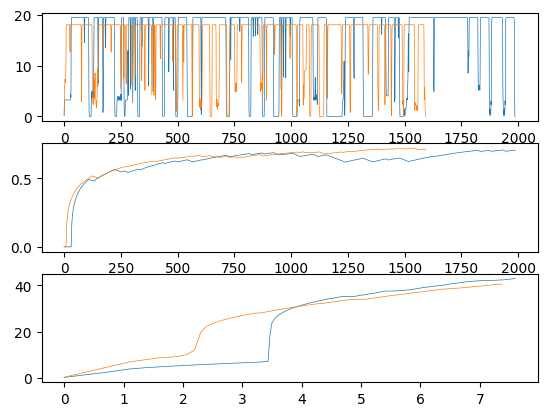

In [138]:
import math

def get_exhaust(density, cp, recovery_fac, curve_fac, overall_fac):
    exhaust = 0
    #overall_exhaust = 0
    exhaust_arr = []
    for d in density:
        exhaust_arr.append(exhaust)
        if d <= cp:
            exhaust *= recovery_fac * (1 - (1-recovery_fac)*0.57*d/cp)
            #exhaust *= recovery_fac
        else:
            exhaust += math.exp(-exhaust / curve_fac) * (d-cp)
            #exhaust += math.exp(-exhaust) * (d-cp) * curve_fac
            #exhaust += 1/(exhaust+1) * (d-cp) * curve_fac
            #exhaust += (d-cp) * curve_fac
        #overall_exhaust += d * overall_fac
        #overall_exhaust += 1/(overall_exhaust+1) * d * overall_fac
    overall_exhaust = overall_fac * np.log(np.cumsum(density) + 1)
    return (np.array(exhaust_arr) + overall_exhaust)*0.01

def do_plots(ax, density):
    x = np.arange(0, len(density))
    # density
    ax[0].plot(x, density, lw=0.5)
    # exhaust
    exh = get_exhaust(density, 7.390e+00, 9.99e-01, 10.999e+00, 1.075e-2)
    ax[1].plot(x, exh, lw=0.5)
    # diff points over time
    p = np.log(np.cumsum((np.power(3.034e+00, density*(1 + exh))-1))+1)
    ax[2].plot(np.log(x+1), p, lw=0.5)

idx1 = df[df['Name'].str.contains(r'\[29\] \[291\]')].index[0]
idx2 = df[df['Name'].str.contains(r'Arc Stream Works')].index[0]
d1 = all_data[idx1][1]
d2 = all_data[idx2][1]

# 6, 0.92, 0.05
fig, ax = plt.subplots(3)
do_plots(ax, d1)
do_plots(ax, d2)
plt.show()

In [ ]:
from statsmodels.miscmodels.ordinal_model import OrderedModel

def predict_one(data, a, cp, recovery_fac, curve_fac, overall_fac):
    #print(data)
    # tired = ewma_vectorized_safe(data, 2/(span+1))
    exhaust = 1 + get_exhaust(data, cp, recovery_fac, curve_fac, overall_fac)
    score = np.log(((np.power(a, data*exhaust) - 1)).sum() + 1)
    #score = np.log((np.power(a, data*exhaust) - 1).sum() + 1)
    #score = np.log(np.power(data, 2).sum())
    return score


def predict(a, cp, recovery_fac, curve_fac, overall_fac, dataset=all_data):
    meters = dataset.meters
    scores = []
    for data in dataset.data:
        score = predict_one(data, a, cp, recovery_fac, curve_fac, overall_fac)
        scores.append(score)
    x = np.array(scores).reshape((-1, 1))
    y = np.array(meters)
    return x, y

# x, y = predict(2.28744856, 41.85642433)
#x, y = predict(2.28744856, 6, 0.92, 0.05)

#x, y = predict(2.443e+00,  1.613e+01,  9.166e-01,  1.862e-02)
#x, y = predict(3.42119342, 7.37242798, 0.94126975, 0.15030075, 0)
# 0.6720312118995367 0.4174418007280254
# balanced: 0.5562058034625701 0.549607495849428

#params = [3.529e+00,  6.816e+00,  9.433e-01,  2.669e+00,  2.286e-04]
# 0.6659351377712753 0.42104402417689946

# with 1/x exhaust, linear overall exhaust
#params = [3.034e+00,  5.070e+00,  8.871e-01,  2.995e+00,  1.524e-05]

# with trimmed down data
#params = [3.034e+00, 5.661e+00, 8.329e-01, 2.890e+00, 6.859e-04]
# 0.6662416321326108 0.41417643537840865 0.28652988696439685
# with mse
#params = [3.034e+00, 5.209e+00, 8.332e-01, 2.951e+00, 6.859e-04]
# 0.665604080331527 0.4156943674421414 0.28719529008438466

# with moving exhaust mult into the exponent
params = [3.034e+00, 7.390e+00, 9.444e-01, 4, 1.075e-03]
# 0.649346509403889 0.4253711221630721 0.28925628386094165
# expand bounds for curve_fac
params = [3.356e+00, 9.446e+00, 9.725e-01, 5.560e+00, 1.760e-03]
# 0.6318138348740835 0.4442055718067327 0.3183737000875278

# changed how logarithmic growth works? i dont remember
params = [2.387e+00, 7.309e+00, 9.702e-01, 4.660e+00, 4.047e-03]
# 0.7095951546063117 0.3803224565289485 0.24545786923064408
x, y = predict(*params)


In [38]:
x, y

(array([[16.70547373],
        [17.27505797],
        [16.98641801],
        ...,
        [28.63915597],
        [25.39166582],
        [26.26475449]]),
 array([11, 11, 11, ..., 24, 21, 20]))

In [203]:
predictor = Predictor(43, params)
predictor.fit(x, y)
ps = predictor.predict_proba(x)
pred_avg = np.sum((ps * np.arange(1, 44)), -1)
print(predictor.acc(x, y), predictor.mae(x, y), predictor.mse(x, y))
print(y)

0.7095951546063117 0.3803224565289485 0.24545786923064408
[11 11 11 ... 24 21 20]


In [60]:
from bokeh.models.tickers import BasicTicker
def bokeh_display(X, y, names_df=None, predictor=None, palette=palettes.Turbo256*2):

    disp_df = pd.DataFrame(index=names_df.index)
    disp_df['y'] = y
    disp_df['x'] = X
    disp_df = disp_df.merge(names_df[['Name', 'Meter']], left_index=True, right_index=True)

    datasource = ColumnDataSource(disp_df)
    color_mapping = LinearColorMapper(
        palette=palette
    )

    plot_figure = figure(
        width=500,
        height=500,
        tools=('pan, wheel_zoom, reset')
    )

    hvr = HoverTool(tooltips="""
    <div>
        <div>
            <span style='font-size: 12px; color: #224499'>[@x]</span>
            <span style='font-size: 12px; color: #994422'>[@y]</span>
            <span style='font-size: 12px'>@Name</span>
        </div>
    </div>
    """)
    plot_figure.add_tools(hvr)

    scatter = plot_figure.scatter(
        'x',
        'y',
        source=datasource,
        #color=dict(field='Meter', transform=color_mapping),
        #color='black',
        line_alpha=0,
        fill_alpha=0.05,
        size=8
    )
    hvr.renderers = [scatter]
    
    if predictor:
        xs = np.arange(0, 45, 0.02)
        ys = predictor.predict_weighted_avg(xs.reshape(-1, 1))
        
        plot_figure.line(x=ys, y=xs, color='#f008')
        plot_figure.line(x=np.round(ys), y=xs, color='#0008')
    plot_figure.ygrid.ticker = BasicTicker(min_interval=1, max_interval=1)
    show(plot_figure)

In [146]:
bokeh_display(y, x.reshape((-1,)), df, predictor=predictor)

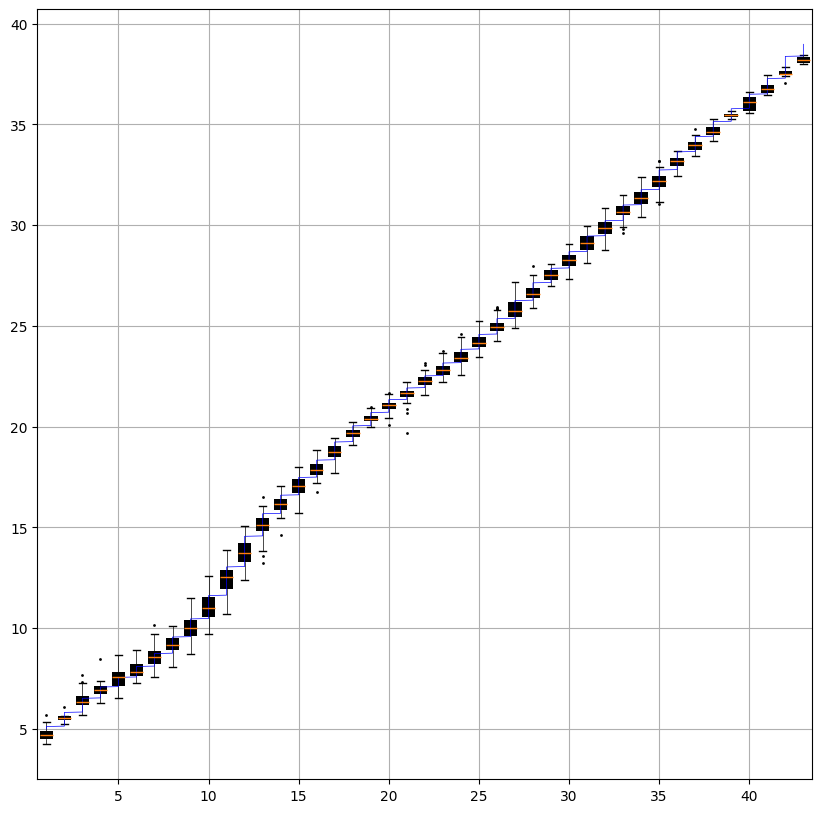

In [174]:
import matplotlib.ticker as pltticker

box_df = pd.DataFrame({'Score': x.reshape((-1,)), 'Meter': df['Meter']})
labels = list(range(1, 44))
box_data = []
for i in labels:
    box_data.append(box_df[box_df['Meter'] == i]['Score'])
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)


xs = np.arange(5, 39, 0.02)
ys = predictor.predict_weighted_avg(xs.reshape(-1, 1))

#ax.plot(ys, xs, color='#f008')

ax.boxplot(box_data, patch_artist=True, widths=0.75, boxprops=dict(linewidth=0, facecolor='black'), whiskerprops=dict(linewidth=0.5), flierprops=dict(markersize=1))
# vs = ax.violinplot(box_data)
# for pc in vs['bodies']:
#     pc.set_color('red')
# vs['cbars'].set_linewidth(0.5)
ax.plot(np.round(ys), xs, color='blue', linewidth=0.5)
ticks = np.arange(5, 44, 5)
plt.xticks(ticks, ticks)
ax.grid(True)
plt.show()

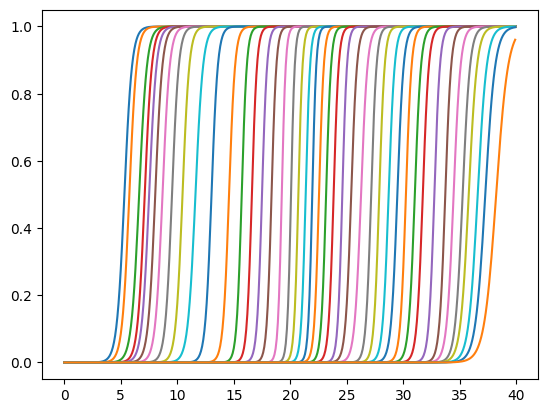

In [148]:
xs = np.arange(0, 40, 0.1).reshape(-1, 1)
for reg in predictor.regs:
    res = reg.predict_proba(xs)[:,1]
    plt.plot(xs, res)
#ys = predictor.predict_weighted_avg(xs.reshape(-1, 1))

plt.show()

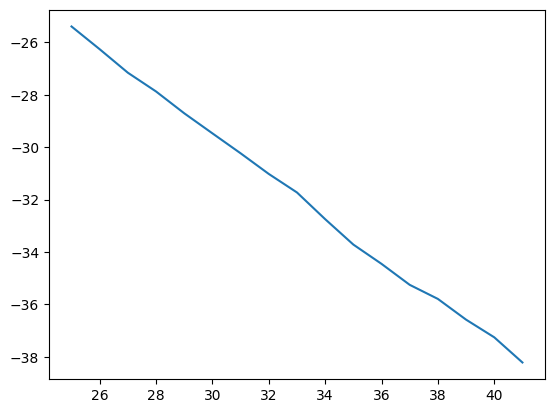

In [184]:
idxs = list(range(25, 42))
coefs = np.asarray([predictor.regs[i].coef_[0][0] for i in idxs])
intercepts = np.asarray([predictor.regs[i].intercept_[0] for i in idxs])
#coefs, intercepts
plt.plot(idxs, intercepts/coefs)
plt.show()

In [222]:
print([r.intercept_ for r in predictor.regs])
dir(predictor.regs[2])

[array([-28.5187554]), array([-27.7942981]), array([-23.41877928]), array([-22.30373903]), array([-24.4339308]), array([-23.92707757]), array([-20.65319651]), array([-18.33054903]), array([-24.53128771]), array([-37.8485838]), array([-43.68767743]), array([-64.44408746]), array([-80.40411704]), array([-82.39889377]), array([-90.3695584]), array([-99.91593422]), array([-129.21249378]), array([-135.75991641]), array([-123.55788618]), array([-125.89190948]), array([-141.68497957]), array([-118.90293241]), array([-120.25853515]), array([-119.74812503]), array([-128.83170019]), array([-110.43537161]), array([-111.45605563]), array([-121.6582268]), array([-116.21148361]), array([-111.43930035]), array([-105.91851472]), array([-121.20225133]), array([-109.77569155]), array([-115.6616418]), array([-132.77413384]), array([-123.39536456]), array([-121.30616211]), array([-114.33303117]), array([-108.32807672]), array([-79.26577998]), array([-88.09672278]), array([-63.07567339])]


['C',
 '__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__sklearn_clone__',
 '__sklearn_tags__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_build_request_for_signature',
 '_doc_link_module',
 '_doc_link_template',
 '_doc_link_url_param_generator',
 '_estimator_type',
 '_get_default_requests',
 '_get_doc_link',
 '_get_metadata_request',
 '_get_param_names',
 '_get_params_html',
 '_html_repr',
 '_parameter_constraints',
 '_predict_proba_lr',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_validate_params',
 'class_weight',
 'classes_',
 'coef_',
 'decision_function',
 'densify',
 'dual',
 'fit',
 'fit_intercept',
 'get_metadata_routing',
 'get_

In [ ]:
mod_log = OrderedModel(y, x, distr='logit')
res_log = mod_log.fit(method='bgfs', disp=False)
res_log.summary()

KeyboardInterrupt: 

In [81]:
preds = res_log.model.predict(res_log.params, exog=x)

In [90]:
pred_choice = preds.argmax(1) + 1
print((y == pred_choice).mean())
pred_avg = np.sum((preds * np.arange(1, 44)), -1)
print(np.abs(y - pred_avg).mean())

0.6408193123628383
0.4529980444391331


In [142]:
from scipy.optimize import minimize, basinhopping, direct, shgo

def get_acc(a):
    x, y = predict(a[0], a[1], a[2], a[3], a[4])
    #mod_log = OrderedModel(y, x, distr='logit')
    #res_log = mod_log.fit(method='bfgs', disp=False)
    #preds = res_log.model.predict(res_log.params, exog=x)
    #pred_choice = preds.argmax(1) + 1
    #acc = (y == pred_choice).mean()
    p = Predictor(43, a)
    p.fit(x, y)
    acc = p.mae(x, y)
    print('call:', a, acc)
    return acc

#res = minimize(get_acc, [1.5, 60], bounds=[(1, 4), (20, 100)])
#res = basinhopping(get_acc, [2, 60])
# call: [ 2.33193333 40.96718446] 0.4532350091963813

res2 = direct(get_acc, bounds=[(1.1, 4), (1, 15), (0.8, 1), (1, 10), (0, 0.1)], vol_tol=1e-17, maxfun=10000)
#res = shgo(get_acc, bounds=[(1.1, 4), (1, 20), (0.5, 1), (0, 3), (0, 0.1)])
# res = basinhopping(get_acc, [2.28744856, 6, 0.92, 0.05])


# res = [get_acc((2.2, span)) for span in np.arange(10, 60, 5)]
# call: (2.2, 10) 0.6100414330977334
# call: (2.2, 15) 0.6212527418961735
# call: (2.2, 20) 0.628808189129905
# call: (2.2, 25) 0.6353887399463807
# call: (2.2, 30) 0.6390446015110894
# call: (2.2, 35) 0.6392883256154034
# call: (2.2, 40) 0.6405069461369729
# call: (2.2, 45) 0.6409943943456008
# call: (2.2, 50) 0.6400194979283451
# call: (2.2, 55) 0.6395320497197173

call: [2.55 8.   0.9  5.5  0.05] 0.41192871356264094
call: [3.51666667 8.         0.9        5.5        0.05      ] 0.4720219971234885
call: [1.58333333 8.         0.9        5.5        0.05      ] 0.7331798489499377
call: [ 2.55       12.66666667  0.9         5.5         0.05      ] 0.4666164087504523
call: [2.55       3.33333333 0.9        5.5        0.05      ] 0.4337067942221412
call: [2.55       8.         0.96666667 5.5        0.05      ] 0.39101787139407
call: [2.55       8.         0.83333333 5.5        0.05      ] 0.42597126715035205
call: [2.55 8.   0.9  8.5  0.05] 0.4522170624313062
call: [2.55 8.   0.9  2.5  0.05] 0.42959958640470913
call: [2.55       8.         0.9        5.5        0.08333333] 0.4116013567012707
call: [2.55       8.         0.9        5.5        0.01666667] 0.41197827146666854
call: [3.51666667 8.         0.96666667 5.5        0.05      ] 0.4465316737160571
call: [1.58333333 8.         0.96666667 5.5        0.05      ] 0.7371417306388487
call: [ 2.55     

In [91]:
res

 message: Optimization terminated successfully.
 success: True
     fun: 0.3581448514255309
    funl: [ 3.581e-01]
       x: [ 2.923e+00  1.201e+00  7.320e-01  1.500e+00  4.021e-07]
      xl: [[ 2.923e+00  1.201e+00  7.320e-01  1.500e+00  4.021e-07]]
     nit: 1
    nfev: 1162
   nlfev: 1129
   nljev: 100
   nlhev: 0

In [143]:
res2

 message: Number of function evaluations done is larger than maxfun=10000
 success: False
  status: 1
     fun: 0.3803114694652023
       x: [ 2.387e+00  7.309e+00  9.702e-01  4.660e+00  4.047e-03]
     nit: 749
    nfev: 10009

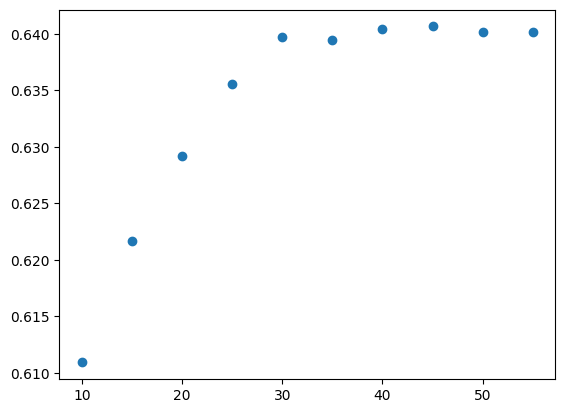

In [63]:
plt.scatter(np.arange(10, 60, 5), res)
plt.show()

In [106]:
xs = np.arange(0, 10, 0.25)
mses = [get_acc((3.034e+00, 7.390e+00, 9.444e-01, a, 1.075e-03)) for a in xs]

call: (3.034, 7.39, 0.9444, 0.0, 0.001075) 0.4703094519796116
call: (3.034, 7.39, 0.9444, 0.25, 0.001075) 0.3909731592957304
call: (3.034, 7.39, 0.9444, 0.5, 0.001075) 0.3639903658527475
call: (3.034, 7.39, 0.9444, 0.75, 0.001075) 0.34597978472156893
call: (3.034, 7.39, 0.9444, 1.0, 0.001075) 0.33259369421307927
call: (3.034, 7.39, 0.9444, 1.25, 0.001075) 0.32215529822180866
call: (3.034, 7.39, 0.9444, 1.5, 0.001075) 0.3138728679782513
call: (3.034, 7.39, 0.9444, 1.75, 0.001075) 0.30740538908494497
call: (3.034, 7.39, 0.9444, 2.0, 0.001075) 0.3018336385975317
call: (3.034, 7.39, 0.9444, 2.25, 0.001075) 0.297656436872067
call: (3.034, 7.39, 0.9444, 2.5, 0.001075) 0.2940681115237744
call: (3.034, 7.39, 0.9444, 2.75, 0.001075) 0.2913303518381439
call: (3.034, 7.39, 0.9444, 3.0, 0.001075) 0.2892499463205639
call: (3.034, 7.39, 0.9444, 3.25, 0.001075) 0.28769621835648035
call: (3.034, 7.39, 0.9444, 3.5, 0.001075) 0.28669662423029646
call: (3.034, 7.39, 0.9444, 3.75, 0.001075) 0.286255177396

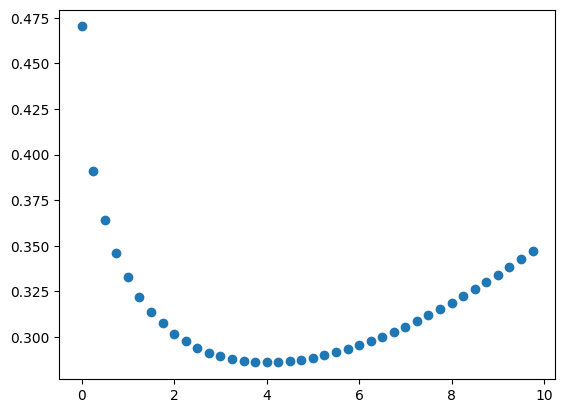

In [107]:
plt.scatter(xs, mses)
plt.show()

In [149]:
from analysis.analyzer import SongAnalyzer
from analysis.hash import get_hash
import math
from typing import Iterable, Iterator
from collections import deque

SPACING = 1
SUPPORT_RADIUS = 1.5 * SPACING
def _kernel(x):
    x = (x / SPACING) + 1.5
    if x <= 1:
        y = x * x / 2
    elif x <= 2:
        y = (2 - x) * (x - 1) + 0.5
    else:
        x = x - 3
        y = x * x / 2
    return y / SPACING

def get_seq(note_times: Iterable[float]) -> Iterator[float]:
    note_times = iter(note_times)
    queue = deque()
    # raises StopIteration if note_times is empty, which is desired
    first = next(note_times, None)
    if first is None:
        return
    sample_loc = math.ceil((first - SUPPORT_RADIUS) / SPACING) * SPACING
    queue.append(first)
    while queue:
        lbound = sample_loc - SUPPORT_RADIUS
        rbound = sample_loc + SUPPORT_RADIUS
        # add new notes, ensuring last note in queue is beyond the
        # window, if possible
        if queue[-1] < rbound:
            next_note = next(note_times, None)
            while next_note is not None and next_note < rbound:
                queue.append(next_note)
                next_note = next(note_times, None)
            if next_note is not None:
                queue.append(next_note)
        # clear old notes
        while queue and queue[0] < lbound:
            queue.popleft()

        accum = 0
        for time in queue:
            if time < rbound:
                accum += _kernel(sample_loc - time)
        yield accum
        sample_loc += SPACING

def handle_song(song, pack_name, seen_hashes):
    data = []
    song_analyzer = SongAnalyzer(song)
    song_str = f'{pack_name}/{song.title or ""}'

    for chart_analyzer in song_analyzer.chart_analyzers.values():
        chart = chart_analyzer.chart
        if (chart.stepstype or '').lower() != 'dance-single':
            continue
        diff = (chart.difficulty or '').lower()
        title = song_str
        if diff != 'challenge':
            title += f' ({diff})'

        chart_hash = get_hash(song, chart_analyzer.chart)
        if chart_hash in seen_hashes:
            print(f'skipping {title} (dupe hash)')
            continue
        seen_hashes.add(chart_hash)
        print(f'analyzing {title}')
        try:
            meter = int(chart_analyzer.chart.meter)
        except ValueError:
            print(song.title, ': invalid meter')
            continue

        note_times = chart_analyzer.get_note_times()
        seq = list(get_seq(note_times))
        if not seq:
            print(title, ': empty?')
            continue
        # print(seq)

        data.append((
            title,
            chart_hash,
            meter,
            str(seq)
        ))
    return data

c:\Users\Lenovo\Documents\code_projs\itg-difficulty-predictor\.venv\Lib\site-packages\fs\__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)  # type: ignore


In [215]:
def make_seq(bpm, measures):
    nps = bpm / 60 * 4
    length = math.floor(60 / bpm * 4 * measures + 1)
    last_val = 16*measures - nps*(length-1)
    arr = [nps] * length
    arr[-1] = last_val
    return np.array(arr)

seq = make_seq(500, 379)
p = predictor.to_score(seq)
print(predictor.predict_weighted_avg(np.array([[p]]), True) + 0.5)

for b in range(10, 710, 10):
    seq = make_seq(b, 32)
    p = predictor.to_score(seq)
    print(b, predictor.predict_weighted_avg(np.array([[p]]), True) + 0.5)

[49.19719058]
10 [3.82216994]
20 [4.34982426]
30 [5.02323459]
40 [5.80518052]
50 [6.58793811]
60 [7.32387416]
70 [7.97322063]
80 [8.55481973]
90 [9.11613914]
100 [9.63028873]
110 [10.19628093]
120 [11.02483363]
130 [11.49490895]
140 [12.00328028]
150 [12.45747497]
160 [12.81295834]
170 [13.39173654]
180 [13.96041977]
190 [14.67507727]
200 [15.43547078]
210 [16.17498493]
220 [16.9185363]
230 [17.61698852]
240 [18.490256]
250 [19.39107302]
260 [20.42563067]
270 [21.49135559]
280 [22.69731561]
290 [23.77148265]
300 [24.79645659]
310 [25.7129011]
320 [26.73825002]
330 [27.55423535]
340 [28.29718076]
350 [29.16403532]
360 [30.21212576]
370 [31.08048221]
380 [32.08206253]
390 [33.03831701]
400 [34.09765804]
410 [35.05631044]
420 [35.90904965]
430 [36.91681617]
440 [37.99223243]
450 [39.06620763]
460 [40.04446609]
470 [41.14227541]
480 [42.24928634]
490 [43.26216914]
500 [44.38840258]
510 [45.52193115]
520 [46.56478331]
530 [47.72337063]
540 [48.90084614]
550 [50.0054244]
560 [51.18356677]
57

In [151]:
from simfile.dir import SimfilePack
import simfile
import glob

columns = ['Name', 'Hash', 'Meter', 'Seq']

glob_path = r"C:\Users\Lenovo\AppData\Roaming\ITGmania\Songs\Stamina RPG 9 Unlocks"
#glob_path = r'pack_archive\BLACKLIGHT'
real_test_data = []
seen_hashes = set()
for path in glob.glob(glob_path):
     pack = SimfilePack(path)
     for song in pack.simfiles(strict=False):
          real_test_data.extend(handle_song(song, pack.name, seen_hashes))

#song = simfile.open(r'C:\Users\Lenovo\AppData\Roaming\ITGmania\Songs\BemaniBeats 6\Deadly force\deadly.sm')
#real_test_data.extend(handle_song(song, '_misc', seen_hashes))

test_df = pd.DataFrame(real_test_data, columns=columns)
test_data = ChartDataset(test_df)

analyzing Stamina RPG 9 Unlocks/[11] [146] GDFR
analyzing Stamina RPG 9 Unlocks/[11] [135] mnemonic
analyzing Stamina RPG 9 Unlocks/[12] [143] another station
analyzing Stamina RPG 9 Unlocks/[12] [128] BUNGEE
analyzing Stamina RPG 9 Unlocks/[12] [135] Datamania
analyzing Stamina RPG 9 Unlocks/[12] [156] Happily Ever After (Hard)
analyzing Stamina RPG 9 Unlocks/[12] [150] Here We Go
analyzing Stamina RPG 9 Unlocks/[12] [142] Megitsune
analyzing Stamina RPG 9 Unlocks/[12] [175] My My My (Hard)
analyzing Stamina RPG 9 Unlocks/[12] [137] Patchwork Eden
analyzing Stamina RPG 9 Unlocks/[12] [164] Rookie (Hard)
analyzing Stamina RPG 9 Unlocks/[12] [222] Say So
analyzing Stamina RPG 9 Unlocks/[12] [220] The End (Feat. BABYMETAL)
analyzing Stamina RPG 9 Unlocks/[12] [128] Winke Verkackt Aufpassen
analyzing Stamina RPG 9 Unlocks/[12] [164] XIII
analyzing Stamina RPG 9 Unlocks/[12] [176] You Will Know Our Names
analyzing Stamina RPG 9 Unlocks/[13] [191] A
analyzing Stamina RPG 9 Unlocks/[13] [145

In [152]:
test_x, test_y = predict(*predictor.params, test_data)

In [153]:
bokeh_display(test_y, test_x.reshape((-1,)), test_df, predictor=predictor)

## Torch tests

In [79]:
all_data_torch = ChartDataset(df, True)

In [81]:
from spacecutter.models import OrdinalLogisticModel
from torch.nn import Parameter

def get_exhaust_torch(density, cp, recovery_fac, curve_fac):
    exhaust = torch.as_tensor(0.0)
    exhaust_arr = torch.empty((len(density),))
    for i, d in enumerate(density):
        exhaust_arr[i] = exhaust
        if d <= cp:
            exhaust *= recovery_fac
        else:
            #exhaust += math.exp(-exhaust*curve_fac) * (d-cp)
            exhaust += 1/(exhaust+1) * (d-cp) * curve_fac
    #print(exhaust_arr)
    return exhaust_arr

def get_exhaust_torch_vectorized(density, cp, recovery_fac, curve_fac):    
    # Create masks
    below_cp = density <= cp
    
    # Find segment boundaries
    condition_change = torch.cat([
        torch.tensor([True]),  # First element always starts a segment
        below_cp[1:] != below_cp[:-1]
    ])
    segment_ids = torch.cumsum(condition_change.long(), dim=0) - 1
    
    exhaust = torch.zeros_like(density, dtype=torch.float32)
    
    for seg_id in range(segment_ids.max() + 1):
        mask = segment_ids == seg_id
        indices = torch.where(mask)[0]
        
        start_idx = indices[0]
        prev_exhaust = exhaust[start_idx - 1].item() if start_idx > 0 else 0.0
        
        if below_cp[start_idx]:
            # Exponential decay: exhaust * recovery_fac^n
            n_steps = torch.arange(len(indices), device=density.device, dtype=density.dtype)
            exhaust[mask] = prev_exhaust * (recovery_fac ** n_steps)
        else:
            # Linear growth: cumulative sum of increments
            increments = (density[mask] - cp) * curve_fac
            cumulative_growth = torch.cumsum(increments, dim=0)
            # Shift by one: exhaust[i] is set BEFORE adding increment[i]
            exhaust[mask] = prev_exhaust + torch.cat([
                torch.tensor([0.0]), 
                cumulative_growth[:-1]
            ])
    
    return exhaust

@torch.jit.script
def get_exhaust_jit(density: torch.Tensor, cp: torch.Tensor, 
                     recovery_fac: torch.Tensor, curve_fac: torch.Tensor,
                     temperature: float = 0.1) -> torch.Tensor:
    n = density.shape[0]
    exhaust = torch.zeros(n, dtype=torch.float32)
    exhaust_val = torch.tensor(0.0)
    
    for i in range(n):
        exhaust[i] = exhaust_val
        
        is_below = torch.sigmoid(-(density[i] - cp) / temperature)
        decay_val = exhaust_val * recovery_fac
        growth_val = exhaust_val + (density[i] - cp) * curve_fac
        
        exhaust_val = is_below * decay_val + (1 - is_below) * growth_val
    
    return exhaust

class TorchPredictor(nn.Module):
    def __init__(self):
        super().__init__()

        self.a = Parameter(torch.tensor(2.0, dtype=torch.float32))
        self.cp = Parameter(torch.tensor(6.0, dtype=torch.float32))
        self.recovery_fac = Parameter(torch.tensor(0.9, dtype=torch.float32))
        self.curve_fac = Parameter(torch.tensor(1.0, dtype=torch.float32))

    def init_weights(self):
        with torch.no_grad():
            self.a.data.fill_(2.0)
            self.cp.data.fill_(6.0)
            self.recovery_fac.data.fill_(0.9)
            self.curve_fac.data.fill_(1.0)
    
    def clamp_params(self):
        with torch.no_grad():
            self.a.clamp_(1.1, 4)
            self.cp.clamp_(1, 20)
            self.recovery_fac.clamp_(0.8, 1)
            self.curve_fac.clamp_(0.1, 10)

    def forward(self, data):
        #print('new data', data.shape)
        scores = torch.empty((len(data),))
        for i, row in enumerate(data):
            #if i % 10 == 0: print('.', end='')
            #length = int(row[0])
            #row = row[1:length + 1]
            exhaust = 1 + get_exhaust_jit(row, self.cp, self.recovery_fac, self.curve_fac)
            p = torch.pow(self.a, row) - 1
            #print(exhaust.device, p.device, row.device, data.device)
            score = torch.log((p * exhaust).sum() + 1)
            scores[i] = score
        #print()
        return scores.unsqueeze(1)

#pre_pad = [torch.tensor(np.insert(i, 0, len(i), axis=0)) for i in all_data.data[0:2]]
pre_pad = all_data_torch.data[:2]
padded = torch.nn.utils.rnn.pad_sequence(
    pre_pad, batch_first=True, padding_value=0.0
)
print(padded.shape)
predictor = TorchPredictor()
predictor.init_weights()
model = OrdinalLogisticModel(predictor, 43)
predictor(padded)


torch.Size([2, 169])


tensor([[14.3251],
        [15.2532]], grad_fn=<UnsqueezeBackward0>)

In [82]:
import random
from spacecutter.callbacks import AscensionCallback
from spacecutter.losses import CumulativeLinkLoss

callback = AscensionCallback()

def train(model, dataset, optimizer, criterion, n_epoch=10, batch_size=64):
    # Keep track of losses for plotting
    current_loss = 0
    all_losses = []
    model.train()

    print(f"training on data set with n = {len(dataset)}")

    for epoch_i in range(1, n_epoch + 1):
        model.zero_grad() # clear the gradients

        # create some minibatches
        # we cannot use dataloaders because each of our names is a different length
        batches = list(range(len(dataset)))
        random.shuffle(batches)
        batches = np.array_split(batches, len(batches) // batch_size )

        for idx, batch in enumerate(batches):
            batch_loss = 0
            for i in batch: #for each example in this batch
                meter, density = dataset[i]
                output = model.forward(density.reshape((1, -1)))
                output = torch.sum((output * torch.arange(1, 44)), -1)
                loss = criterion(output, meter)
                batch_loss += loss

            # optimize parameters
            batch_loss.backward()
            # nn.utils.clip_grad_norm_(rnn.parameters(), 3)
            optimizer.step()
            optimizer.zero_grad()

            current_loss += batch_loss.item() / len(batch)

            model.predictor.clamp_params()
            callback.clip(model.link)

            print(f'epoch {epoch_i} batch {idx}/{len(batches)}: loss {batch_loss.item() / len(batch)}')

        all_losses.append(current_loss / len(batches) )
        print(f"{epoch_i} ({epoch_i / n_epoch:.0%}): \t average batch loss = {all_losses[-1]}")
        current_loss = 0

    return all_losses

predictor = TorchPredictor()
predictor.init_weights()
model = OrdinalLogisticModel(predictor, 43)
optimizer = torch.optim.Adam(model.parameters(), lr=0.2)
criterion = nn.MSELoss() #CumulativeLinkLoss()
all_losses = train(model, all_data_torch, optimizer, criterion)

training on data set with n = 3137


c:\Users\Lenovo\Documents\code_projs\itg-difficulty-predictor\.venv\Lib\site-packages\torch\utils\_device.py:104: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return func(*args, **kwargs)


epoch 1 batch 0/49: loss 468.1190204326923
epoch 1 batch 1/49: loss 432.4773254394531
epoch 1 batch 2/49: loss 370.85107421875
epoch 1 batch 3/49: loss 319.9359130859375
epoch 1 batch 4/49: loss 240.8506317138672
epoch 1 batch 5/49: loss 166.63929748535156
epoch 1 batch 6/49: loss 180.49960327148438
epoch 1 batch 7/49: loss 167.32994079589844
epoch 1 batch 8/49: loss 189.5996551513672
epoch 1 batch 9/49: loss 170.43775939941406
epoch 1 batch 10/49: loss 110.79187774658203
epoch 1 batch 11/49: loss 120.38109588623047
epoch 1 batch 12/49: loss 132.0061492919922
epoch 1 batch 13/49: loss 155.17120361328125
epoch 1 batch 14/49: loss 130.63937377929688
epoch 1 batch 15/49: loss 135.3848876953125
epoch 1 batch 16/49: loss 132.0145263671875
epoch 1 batch 17/49: loss 114.27297973632812
epoch 1 batch 18/49: loss 128.8717803955078
epoch 1 batch 19/49: loss 126.8470458984375
epoch 1 batch 20/49: loss 109.42591094970703
epoch 1 batch 21/49: loss 83.80388641357422
epoch 1 batch 22/49: loss 97.98650

In [76]:
all_losses_2 = all_losses + all_losses_3

In [71]:
all_losses_3 = train(model, all_data_torch, optimizer, criterion, n_epoch=30)

training on data set with n = 3137


c:\Users\Lenovo\Documents\code_projs\itg-difficulty-predictor\.venv\Lib\site-packages\torch\utils\_device.py:104: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return func(*args, **kwargs)


1 (3%): 	 average batch loss = 0.42935194988827124
2 (7%): 	 average batch loss = 0.42268605829688777
3 (10%): 	 average batch loss = 0.41240327769489826
4 (13%): 	 average batch loss = 0.3879203762092994
5 (17%): 	 average batch loss = 0.3927660571536988
6 (20%): 	 average batch loss = 0.389337077086537
7 (23%): 	 average batch loss = 0.3785747273610188
8 (27%): 	 average batch loss = 0.40089996189487226
9 (30%): 	 average batch loss = 0.3747033819766771
10 (33%): 	 average batch loss = 0.39487809741422186
11 (37%): 	 average batch loss = 0.36280196899521855
12 (40%): 	 average batch loss = 0.36109698710486504
13 (43%): 	 average batch loss = 0.3579294020658011
14 (47%): 	 average batch loss = 0.3536988897591221
15 (50%): 	 average batch loss = 0.36305359329683257
16 (53%): 	 average batch loss = 0.35619166147671466
17 (57%): 	 average batch loss = 0.34662699338218295
18 (60%): 	 average batch loss = 0.35344240204131394
19 (63%): 	 average batch loss = 0.3574032872540985
20 (67%): 	 a

In [72]:
list(model.parameters())

[Parameter containing:
 tensor(2.3201, requires_grad=True),
 Parameter containing:
 tensor(17.5264, requires_grad=True),
 Parameter containing:
 tensor(0.8000, requires_grad=True),
 Parameter containing:
 tensor(0.1000, requires_grad=True),
 Parameter containing:
 tensor([ 7.1923,  7.2177,  7.2692,  7.2736,  7.2761,  7.2861,  7.3292,  7.7303,
         10.9453, 10.9498, 11.7326, 14.5587, 14.5646, 14.5796, 14.5849, 15.9687,
         17.8961, 18.3348, 18.3439, 18.3530, 18.3600, 18.3661, 18.3727, 18.3783,
         22.4498, 22.9345, 24.3501, 24.9932, 25.7555, 27.0193, 27.6003, 27.8188,
         27.9032, 27.9340, 30.8282, 30.8299, 32.5532, 32.6200, 32.6596, 32.6597,
         32.6598, 32.7083], requires_grad=True)]

In [73]:
model.eval()
scores = []
pred_meters = []
meters = []
with torch.no_grad():
    for meter, density in all_data_torch:
        output = model(density.reshape((1, -1)))
        avg = torch.sum((output * torch.arange(1, 44)), -1)
        scores.append(model.predictor(density.reshape((1, -1))).item())
        pred_meters.append(avg.item())
        meters.append(meter.item())
        #print(avg, meter)

In [67]:
scores, meters

([tensor([[10.9138]]),
  tensor([[11.0547]]),
  tensor([[10.8959]]),
  tensor([[10.5898]]),
  tensor([[11.0140]]),
  tensor([[10.5737]]),
  tensor([[10.9128]]),
  tensor([[11.3243]]),
  tensor([[10.0415]]),
  tensor([[10.4481]]),
  tensor([[10.6130]]),
  tensor([[10.9563]]),
  tensor([[11.0320]]),
  tensor([[11.5681]]),
  tensor([[12.3018]]),
  tensor([[12.2364]]),
  tensor([[11.8676]]),
  tensor([[11.9113]]),
  tensor([[11.1665]]),
  tensor([[12.1820]]),
  tensor([[12.2576]]),
  tensor([[11.8340]]),
  tensor([[12.2052]]),
  tensor([[11.8486]]),
  tensor([[12.3026]]),
  tensor([[12.1114]]),
  tensor([[11.5891]]),
  tensor([[12.2810]]),
  tensor([[11.3942]]),
  tensor([[12.1938]]),
  tensor([[11.7758]]),
  tensor([[11.7463]]),
  tensor([[12.5977]]),
  tensor([[12.8465]]),
  tensor([[13.1513]]),
  tensor([[12.3891]]),
  tensor([[12.3248]]),
  tensor([[12.9234]]),
  tensor([[12.6001]]),
  tensor([[12.4457]]),
  tensor([[12.5673]]),
  tensor([[12.4890]]),
  tensor([[12.4855]]),
  tensor([[

In [75]:
bokeh_display(meters, pred_meters, df)

In [27]:
model.link

LogisticCumulativeLink()

In [131]:
from skorch import NeuralNet

from spacecutter.callbacks import AscensionCallback
from spacecutter.losses import CumulativeLinkLoss
from skorch.callbacks import Callback

class Printer(Callback):
    def on_batch_begin(self, net, *args, **kwargs) -> None:
        print('hi')
    def on_batch_end(self, net, *args, **kwargs) -> None:
        print('bye')

predictor = TorchPredictor()
predictor.init_weights()
skorch_model = NeuralNet(
    module=OrdinalLogisticModel,
    module__predictor=predictor,
    module__num_classes=43,
    criterion=CumulativeLinkLoss,
    train_split=None,
    callbacks=[
        ('ascension', AscensionCallback()),
        #('printer', Printer()),
    ],
    batch_size=64
    #device='cuda'
)

pre_pad = [torch.tensor(np.insert(i, 0, len(i), axis=0)) for i in all_data.data[:500]]
padded = torch.nn.utils.rnn.pad_sequence(
    pre_pad, batch_first=True, padding_value=0.0
)
skorch_model.fit(padded, torch.as_tensor(all_data.meters[:500], dtype=torch.int64).unsqueeze(1) - 1)

.......


,module,<class 'space...ogisticModel'>
,criterion,<class 'space...tiveLinkLoss'>
,optimizer,<class 'torch.optim.sgd.SGD'>
,lr,0.01
,max_epochs,10
,batch_size,64
,iterator_train,<class 'torch...r.DataLoader'>
,iterator_valid,<class 'torch...r.DataLoader'>
,dataset,<class 'skorc...aset.Dataset'>
,train_split,None
,callbacks,"[('ascension', ...)]"
